# <center> $🚰 💦\ Pump\ it\ Up:Data\ Mining\ the\ Water\ Table\$ 

## <center> $Григорий\ Хомюк\$
    
<img src='images/place_pump.png' />
<img src='images/pumping.jpg' />

<div class="alert alert-info">

Данная работа основана на соревновании: **https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/**
    
---
    
**Акцент** в исследовании сделан на тюнинг моделей таких, как: `Catboost`, `Xgboost`, `RandomForest`, `KNN`; и их последующий `stacking`.  
    
---   
    
**Задача**: используя данные Таарифы и Министерства водного хозяйства Танзании, предсказать, какие **водяные насосы** **работают**, какие **требуют ремонта**, а какие вообще **не работают**?
    
---
#### $Метрика\ качества$: ***Accuracy***

<div class="alert alert-info">

### data description:    
    
`amount_tsh` - Total static head (amount water available to waterpoint)

`date_recorded` - The date the row was entered

`funder` - Who funded the well

`gps_height` - Altitude of the well

`installer` - Organization that installed the well

`longitude` - GPS coordinate

`latitude` - GPS coordinate

`wpt_name` - Name of the waterpoint if there is one

`num_private` -

`basin` - Geographic water basin

`subvillage` - Geographic location

`region` - Geographic location

`region_code` - Geographic location (coded)

`district_code` - Geographic location (coded)

`lga` - Geographic location

`ward` - Geographic location

`population` - Population around the well

`public_meeting` - True/False

`recorded_by` - Group entering this row of data

`scheme_management` - Who operates the waterpoint

`scheme_name` - Who operates the waterpoint

`permit` - If the waterpoint is permitted

`construction_year` - Year the waterpoint was constructed

`extraction_type` - The kind of extraction the waterpoint uses

`extraction_type_group` - The kind of extraction the waterpoint uses

`extraction_type_class` - The kind of extraction the waterpoint uses

`management` - How the waterpoint is managed

`management_group` - How the waterpoint is managed

`payment` - What the water costs

`payment_type` - What the water costs

`water_quality` - The quality of the water

`quality_group` - The quality of the water

`quantity` - The quantity of water

`quantity_group` - The quantity of water

`source` - The source of the water

`source_type` - The source of the water

`source_class` - The source of the water

`waterpoint_type` - The kind of waterpoint

`waterpoint_type_group` - The kind of waterpoint


<h2> Import libraries </h2> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import cross_val_score
import datetime
from datetime import datetime
from numpy import nan
import seaborn as sns
import matplotlib
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import random
from sklearn.feature_selection import RFECV, RFE
import pygeohash as gh
from vecstack import stacking
from sklearn.ensemble import BaggingClassifier
from scipy import stats
from math import prod
from itertools import product
import joblib 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme()  # Тут можно задать стили

<h2>EDA</h2> 

In [2]:
test = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv', sep=',')
train = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv', sep=',')
labels = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv', sep=',')
y_train = labels['status_group']

Для удобства объединим тестовую и обучающую выборку в один датасет: создав колонку **sample**, которая принимает два значения: test и train.

In [3]:
train['sample'] = 'train'
test['sample'] = 'test'

In [4]:
df = pd.concat([train, test], axis = 0).reset_index(drop=True)
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,sample
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,train
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,train
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,train
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train


Таргет имеет 3 класса: ***работающие/не работающие/требующие ремонта насосы***

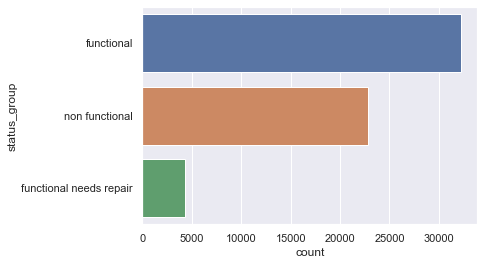

In [5]:
sns.countplot(y_train, palette = sns.color_palette()[:3]);

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 69743 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74248 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             73780 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lg

In [7]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Названия признаков с ненулевым кол-вом пропусков:

In [8]:
[(df.columns[i], j) for i, j in enumerate(df.isnull().sum()) if j > 0]

[('funder', 4507),
 ('installer', 4532),
 ('wpt_name', 2),
 ('subvillage', 470),
 ('public_meeting', 4155),
 ('scheme_management', 4847),
 ('scheme_name', 36052),
 ('permit', 3793)]

Количество уникальных значений по каждому признаку:

In [9]:
# уникальные значения
columns_names = df.columns.to_list()
for i in range(len(df.T)):
    print (columns_names[i], ":", len(df[columns_names[i]].unique()))

id : 74250
amount_tsh : 102
date_recorded : 369
funder : 2140
gps_height : 2456
installer : 2411
longitude : 71870
latitude : 71869
wpt_name : 45684
num_private : 68
basin : 9
subvillage : 21426
region : 21
region_code : 27
district_code : 20
lga : 125
ward : 2098
population : 1128
public_meeting : 3
recorded_by : 1
scheme_management : 12
scheme_name : 2868
permit : 3
construction_year : 55
extraction_type : 18
extraction_type_group : 13
extraction_type_class : 7
management : 12
management_group : 5
payment : 7
payment_type : 7
water_quality : 8
quality_group : 6
quantity : 5
quantity_group : 5
source : 10
source_type : 7
source_class : 3
waterpoint_type : 7
waterpoint_type_group : 6
sample : 2


По вышеописанным статистикам, **под удаление:**

`recorded_by` – имеет одно уникальное значение

`wpt_name` – имеет 45 тысяч уникальных значений

In [10]:
df['num_private'].unique()

array([   0,   39,    5,   45,    6,    3,  698,   32,   15,    7,   25,
        102,    1,   93,   14,   34,  120,   17,  213,   47,    8,   41,
         80,  141,   20,   35,  131,    4,   22,   11,   87,   61,   65,
        136,    2,  180,   38,   62,    9,   16,   23,   42,   24,   12,
        668,  672,   58,  150,  280,  160,   50, 1776,   30,   27,   10,
         94,   26,  450,  240,  755,   60,  111,  300,   55, 1402,  669,
         13,  420])

In [11]:
len(df[
    (df['num_private'] == 0)
])

73299

`num_private` тоже **под удаление**, почти все данные имеют значение 0 в этой колонке.

Признак `subvillage` имеет очень много уникальных значений (21426) и применять к нему **one_hot_encoding** не резонно, но мы попробуем выжать максимум из данных. В дальнейшем, мы удалим неинформативные признаки. 

В фичах с пропущенными значениями мы сделаем отдельную категорию _"my_uniq_na"_.

# Feature Engineering

`date_recorded` – дата проверки водяного насоса на пригодность, а `construction_year` – год постройки. Из этих двух фичей можно сделать новую –> `age`, которая будет отвечать за срок службы объекта. Для такой процедуры напишем специальную функцию, которой передаётся значения признаков, а возвращаемое значение = количество прослуженных лет.

In [12]:
def age(year1, year2):
    recorded_year = datetime.strptime(year1, '%Y-%m-%d').date()
    record = recorded_year.year
    if year2 == 0: 
        return nan
    else: 
        return record - year2

Используя долготу и широту (`longitude`, `latitude`) создадим фичу `geohash`, которая будет отвечать также за географическое расположение объекта. Обрезав значение геохэша до трех знаков, получим около 50 уникальных значений для последующего **one_hot_encoding'a**.

In [13]:
# обрезает строку 
def cuter(s):
    return s[0:3]

# Function for Preprocessing

Для удобства напишем специальную функцию для предобработки, в которой будут включены все действия над данными:

In [14]:
def data_preprocessing(df_input):
    df = df_input.copy()
    #df.reset_index(inplace=True)
    
    df['age'] = df.apply(lambda x: age(x['date_recorded'], x['construction_year']), axis= 1)
    df['age'] = df['age'].fillna(df['age'].mean())
    
    df.drop(columns = ['date_recorded', 'construction_year', 'wpt_name', 'num_private',
                       'recorded_by'], inplace=True)
    
    df['geohash'] = df.apply(lambda x : 
                             gh.encode(x.latitude, x.longitude, precision=5), axis=1)
    df['geohash'] = df['geohash'].map(cuter)
    
    numeric_cols = ['amount_tsh', 'gps_height', 'longitude',
                    'latitude', 'population', 'age']
    
    categorical_cols = list(set(df.columns.values.tolist()) - set(numeric_cols))
    
    
    #categorical_cols.append('region_code')
    #categorical_cols.append('district_code')
    
    categorical_cols.remove('id')
    
    categorical_cols.remove('sample')
    
    
    #for i in range(len(categorical_cols)):
        #print (categorical_cols[i])
    
    X_cat = (df[categorical_cols]).fillna('my_uniq_na')
    X_cat = X_cat.astype(str)
    
    one_hot = pd.get_dummies(X_cat)
    df = df.drop(categorical_cols,axis = 1)
    df = df.join(one_hot)
    
    return df

Эта функция возвращает датафрейм с удалёнными `date_recorded`, `construction_year`, `wpt_name`, `num_private`, `recorded_by` ; с новыми `age` и `geohash` ; ко всем категориальным признакам применяется метод **one_hot_encoding**, а пропущенные значения в таких признаках заменяются на уникальную категорию _"my_uniq"_ ;

In [15]:
df_new = df.pipe(data_preprocessing)

In [16]:
df_new.head(5)

,id,amount_tsh,gps_height,longitude,latitude,population,sample,age,ward_Aghondi,ward_Akheri,...,district_code_5,district_code_53,district_code_6,district_code_60,district_code_62,district_code_63,district_code_67,district_code_7,district_code_8,district_code_80
0,69572,6000.0,1390,34.938093,-9.856322,109,train,12.000000,False,False,...,True,False,False,False,False,False,False,False,False,False
1,8776,0.0,1399,34.698766,-2.147466,280,train,3.000000,False,False,...,False,False,False,False,False,False,False,False,False,False
2,34310,25.0,686,37.460664,-3.821329,250,train,4.000000,False,False,...,False,False,False,False,False,False,False,False,False,False
3,67743,0.0,263,38.486161,-11.155298,58,train,27.000000,False,False,...,False,False,False,False,False,True,False,False,False,False
4,19728,0.0,0,31.130847,-1.825359,0,train,15.295624,False,False,...,False,False,False,False,False,False,False,False,False,False


Следующий код изменяет названия колонок в датафрейме на правильные: убирает некоторые символы _"[ , ] < $"_ . Это необходимо для обучения **xgboost**.

In [17]:
mylist = df_new.columns.values.tolist()

def change_col(mylist):
    dictionary = dict()
    arr = ['[', ',', ']', '<', '$']
    for i in range(len(mylist)):
        key = mylist[i]
        name = mylist[i]
        for x in arr:
            name = name.replace(x, "__")
        dictionary[key] = name
    return dictionary

dictionary = change_col(mylist)
df_new.rename(columns = dictionary, inplace=True)

Отделим обучение и тест:

In [18]:
train = df_new[df_new['sample']=='train'].drop(columns='sample')
test = df_new[df_new['sample']=='test'].drop(columns='sample')

По итогу, получилось 31354 признаков.

In [19]:
train.shape

(59400, 31352)

In [20]:
X_train = train[train.columns[1:]]

In [21]:
X_train.shape

(59400, 31351)

In [22]:
y_train

0            functional
1            functional
2            functional
3        non functional
4            functional
              ...      
59395        functional
59396        functional
59397        functional
59398        functional
59399        functional
Name: status_group, Length: 59400, dtype: object

In [23]:
X_train.head()

,amount_tsh,gps_height,longitude,latitude,population,age,ward_Aghondi,ward_Akheri,ward_Arash,ward_Arri,...,district_code_5,district_code_53,district_code_6,district_code_60,district_code_62,district_code_63,district_code_67,district_code_7,district_code_8,district_code_80
0,6000.0,1390,34.938093,-9.856322,109,12.000000,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,0.0,1399,34.698766,-2.147466,280,3.000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,25.0,686,37.460664,-3.821329,250,4.000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.0,263,38.486161,-11.155298,58,27.000000,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,0.0,0,31.130847,-1.825359,0,15.295624,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


И закодируем наш таргет с помощью `LabelEncoder`:

In [24]:
# таргет необходимо перевести из строкового типа в целочисленный
le_tar = LabelEncoder()
y_train = le_tar.fit_transform(y_train)

# Feature Selection

Проведём **несложный отбор** информативных признаков для дальнейшего обучения моделей, воспользовавшись атрибутом `feature_importances_` в градиентном бустинге `XGBClassifier`. Обучим классификатор с параметрами по умолчанию, на всех признаках:

In [26]:
# setattr(pandas, "Int64Index", pandas.Index)

In [25]:
model = XGBClassifier()

In [27]:
model.fit(X_train, y_train)

Создадим список фичей, которые имеют **показатель информативности не равный нулю** и запишем в файл этот список:

In [28]:
mycolumns = X_train.columns.values.tolist()
imp_feat = []
dictionary = dict()
for i in range(len(model.feature_importances_)):
    if model.feature_importances_[i] != 0:
        value = model.feature_importances_[i]
        key = mycolumns[i]
        dictionary[key] = value
        imp_feat.append(key)
        print(key, value)

In [29]:
# сохранить фичи в файл
features = pd.DataFrame.from_dict(dictionary, orient='index')
features.reset_index(level=0, inplace=True)
col_names = ['feature', 'importance']
features.columns = col_names

In [31]:
features.head(3)

,feature,importance
0,amount_tsh,0.002472
1,gps_height,0.000391
2,longitude,0.001089


In [32]:
features_csv = pd.DataFrame(zip(features['feature'], features['importance']), 
                    columns = ['feature', 'importance']).to_csv('importance_features.csv',
                                                                  sep=',',
                                                                  index=False)

In [30]:
# открытие файла
imp_f = pd.read_csv('importance_features.csv', sep=',')
imp_feat = imp_f['feature'].to_list()

Из 31354 отобрали 233 признака:

In [31]:
print(len(imp_feat)) #было 233

233


Сравним качество бустинга, обученного на всём признаковом пространстве, с обученным только на информативных признаках: 

In [43]:
xgb = XGBClassifier()

In [44]:
X_small = X_train[:30000]
y_small = y_train[:30000]

In [45]:
print(cross_val_score(xgb, X_small[imp_feat], y_small, scoring = 'accuracy', cv=5).mean())

0.7917666666666667


In [46]:
print(cross_val_score(xgb, X_small, y_small, scoring = 'accuracy', cv=5).mean())

0.7886


Как видим, мы **ничего не теряем**, если **убрать неинформативные признаки** и обучаться только на информативных.

А теперь начнём обучать модели на новом признаковом пространстве: 

In [32]:
X_tr = X_train[imp_feat]

In [33]:
X_tr

,amount_tsh,gps_height,longitude,latitude,population,age,district_code_1,district_code_2,district_code_30,district_code_33,...,scheme_name_wanging'ombe water supply s,geohash_kxr,geohash_kxx,geohash_ky2,geohash_ky5,geohash_ky7,geohash_kyg,geohash_kz0,geohash_kz5,geohash_kz8
0,6000.0,1390,34.938093,-9.856322,109,12.000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.0,1399,34.698766,-2.147466,280,3.000000,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2,25.0,686,37.460664,-3.821329,250,4.000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.0,263,38.486161,-11.155298,58,27.000000,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,0.0,0,31.130847,-1.825359,0,15.295624,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,1210,37.169807,-3.253847,125,14.000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
59396,4700.0,1212,35.249991,-9.070629,56,15.000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
59397,0.0,0,34.017087,-8.750434,0,15.295624,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
59398,0.0,0,35.861315,-6.378573,0,15.295624,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [34]:
y_TR = y_train

---

In [35]:
X = X_train[imp_feat]
y = pd.DataFrame({'target':y_train})
# y = np.array(y).ravel() 

# 1 Level: `CatBoostClassifier` 😼

<div class="alert alert-info">

Для градиентного бустинга **Catboost** переберём самые важные гиперпараметры и выберем наилучшую комбинацию в рамках симметричной политики роста деревьев: `grow_policy='SymmetricTree'`

Здесь создадим датафреймы, в к-ые будем загружать информацию о параметрах моделей и их качестве классификации.

In [138]:
BIG = pd.DataFrame(columns = ["iterations",
"depth", "learning_rate", "bootstrap_type", "rsm", "subsample", "l2_leaf_reg",
"cnt_tree0", "cnt_tree1", "cnt_tree2",
"split0_best_iter_learn", "split1_best_iter_learn", "split2_best_iter_learn", "mean_best_iter_learn",
"split0_best_score_val", "split1_best_score_val", "split2_best_score_val", "mean_best_score_val",
"split0_last_score_val", "split1_last_score_val", "split2_last_score_val", "mean_last_score_val"])

In [139]:
BIG.loc[len(BIG.index)] = [0]*len(BIG.columns)
BIG.to_csv('example.csv', sep=';')
# BIG = pd.read_csv('BIG_SUB_L2.csv', sep=';', index_col=0)
# BIG.head()

# <center> 🦾 `CustomSearchCV` ~ Поиск гиперпараметров на кроссвалидации </center>

<div class="alert alert-info">
    
Написанная функция `CustomSearchCV` осуществляет перебор комбинаций гиперпараметров у классификатора `CatboostClassifier` и записывает в таблицу качество на кроссвалидации. Кроссвалидацию используем `StratifiedKFold` на 3 фолда со стратификацией классов. `CustomSearchCV` принимает на вход `mode`: тип поиска – сеткой (*grid*) или рандомизированным способом (*random*); `param_distribution`: словарь, в к-ом ключи – это гиперпараметры, а значения – это распределение параметра/список возможных значений параметра; `filename`: название файла, в к-ый записывать результат. 
    
В таблице будет содержаться информация о значениях гиперпараметров; итоговое количество деревьев **cnt_tree0/cnt_tree1/cnt_tree2** в бустинге, к-ый был настроен на конкретный валидационный фолд; качество ***Accuracy*** на лучшей *(с точки зрения валидацинного фолда)* итерации на обучающих фолдах **split0_best_iter_learn/split1_best_iter_learn/split2_best_iter_learn**, на лучшей итерации на валидационных фолдах **split0_best_score_val/split1_best_score_val/split2_best_score_val** и соответствующее усреднённое **mean_best_score_val**, на последней итерации на валидационных фолдах
**split0_last_score_val/split1_last_score_val/split2_last_score_val** и усреднённое **mean_last_score_val**;

<div class="alert alert-info">

У классификатора `CatboostClassifier` в методе `fit` есть параметр: `use_best_model=True`. Если мы оставим `True`, то модель с заданными параметрами во время кроссвалидации пройдя все `iterations` выберет наилучшую итерацию, при которой `eval_metric` на тестовом фолде был наибольший. Таким образом, для одного набора параметров построится совокупность моделей с разным количеством деревьев для каждого фолда. То же самое касается, если использовать раннюю остановку `early_stopping`. Если мы хотим повторить алгоритм построения, реализованный в `RandomizedSearchCV`, то стоит убрать `early_stopping` и в `fit` использовать `use_best_model=False`, чтобы кол-во деревьев было одно и то же на всех фолдах.

<div class="alert alert-info">

Обучим `catboost`, пользуясь ранней остановкой (*поэтому пользуемся не `RandomizedSearchCV`*): в данном варианте после подбора параметров **на выходе будем иметь совокупность бустингов, обученных с разным кол-вом деревьев на разных фолдах** (*другие параметры будут одинаковые*). Инференс может осуществляться как усреднение ответов всех `n_splits` моделей, но в нашем случае качество выше при обучении одного бустинга на всех обучающих данных.

In [61]:
def generate_params(param_distribution):
    d = {}
    for key in param_distribution.keys():
        if type(param_distribution[key]) is not list:
            d[key] = param_distribution[key].rvs(1)[0]
        else: d[key] = np.random.choice(param_distribution[key], 1)[0]
    return d

In [62]:
def catboost_train_cv(X, y, early_stopping_rounds, params, file_name):
    global BIG
#   global clfs

    BIG = pd.read_csv(file_name, sep=';', index_col=0)

    n_splits = 3           # Число фолдов
    scores_best_learn = [] # Тут будем хранить наилучшие скоры на обученных фолдах
    scores_best_val = []   # Тут будем хранить наилучшие скоры валидационных фолдов
    scores_last_val = []   # Тут будем хранить скоры валидационных фолдов на последней итерации
    cnt_tree = []          # Тут будем хранить итоговое количество деревьев в моделях 
#   clfs = []              # Тут можно сохранять модели
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

    for train_index, test_index in kf.split(X, y):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Специальный класс для ускорения обучения 
        train_dataset = Pool(data=X_train_cv, label=y_train_cv) 
        eval_dataset = Pool(data=X_test_cv, label=y_test_cv)    

        clf = CatBoostClassifier(**params, random_seed=777,
                                 loss_function='MultiClass', eval_metric='Accuracy', early_stopping_rounds=early_stopping_rounds)
        clf.fit(
            train_dataset,
            eval_set=eval_dataset,
            verbose=500,
            use_best_model=True, 
            plot=True)
        scores_best_val.append(clf.best_score_['validation']["Accuracy"]) 
        scores_last_val.append(clf.evals_result_['validation']['Accuracy'][-1:][0])
        scores_best_learn.append(clf.evals_result_['learn']['Accuracy'][clf.best_iteration_])
        cnt_tree.append(clf.tree_count_)
#       clfs.append(clf)
    mean_best_score_learn = np.mean(scores_best_learn)
    mean_best_score_val = np.mean(scores_best_val)
    mean_last_score_val = np.mean(scores_last_val)

    BIG.loc[len(BIG.index)] = list(params.values()) + cnt_tree + scores_best_learn + [mean_best_score_learn] + \
                                  scores_best_val + [mean_best_score_val] + scores_last_val + [mean_last_score_val]
    BIG.to_csv(file_name, sep=';')

In [63]:
def CustomSearchCV(X, y, early_stopping_rounds, mode, param_distribution, filename, n_models=None):
    # mode: 'grid' / 'random'
    
    if mode == 'grid': 
        all_values = list(param_distribution.values())
        n_models = prod([len(all_values[i]) for i in range(len(all_values))])

        for i, parameters in enumerate(product(*all_values)):
            params = dict(zip(param_distribution.keys(), parameters))
            print("Обучается {} из {} моделей".format(i+1, n_models))
            print(params)
            catboost_train_cv(X, y, early_stopping_rounds, params, filename)

    elif mode == 'random':
        #n_models = int(input())
        for i in range(n_models):
            params = generate_params(param_distribution)
            print("Обучается {} из {} моделей".format(i+1, n_models))
            print(params)
            catboost_train_cv(X, y, early_stopping_rounds, params, filename)   

В этой секции задаётся распределение гиперпараметров и вызывается ф-ция их перебора:

In [64]:
mode='grid'
param_distribution = {
    "iterations":       [5000],           
    "depth":            [10],             # [8, 9, 10, 11]
    "learning_rate":    [0.055],          # [0.01, 0.02, 0.027, 0.035, 0.045, 0.055, 0.07]
    "bootstrap_type":   ['MVS'],          # ['Bernoulli', 'MVS', 'Bayesian']
    "rsm":              [0.45],           # [0.3, 0.4, 0.45, 0.5, 0.55, 0.65, 0.7, 0.77, 0.82, 0.88, 1]
    "subsample":        [0.95],           # [0.25, 0.4, 0.55, 0.75, 0.82, 0.88, 0.95, 1]
    "l2_leaf_reg":      [1]               # [1, 3, 5, 7]
} 
filename = 'example.csv' #должен быть заранее создан
# n_models=None          #при моде random
early_stopping_rounds=200
CustomSearchCV(X, y, early_stopping_rounds, mode, param_distribution, filename)

Обучается 1 из 1 моделей
{'iterations': 5000, 'depth': 10, 'learning_rate': 0.055, 'bootstrap_type': 'MVS', 'rsm': 0.45, 'subsample': 0.95, 'l2_leaf_reg': 1}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7068687	test: 0.7018687	best: 0.7018687 (0)	total: 47.3ms	remaining: 3m 56s
500:	learn: 0.8291919	test: 0.7928283	best: 0.7931313 (498)	total: 21.9s	remaining: 3m 16s
1000:	learn: 0.8619697	test: 0.8026263	best: 0.8029293 (995)	total: 45.1s	remaining: 3m
1500:	learn: 0.8841162	test: 0.8058081	best: 0.8061616 (1319)	total: 1m 8s	remaining: 2m 38s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8061616162
bestIteration = 1319

Shrink model to first 1320 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7171717	test: 0.7160606	best: 0.7160606 (0)	total: 62.2ms	remaining: 5m 11s
500:	learn: 0.8267929	test: 0.7980808	best: 0.7980808 (500)	total: 22.8s	remaining: 3m 25s
1000:	learn: 0.8618434	test: 0.8064646	best: 0.8069192 (993)	total: 46.1s	remaining: 3m 4s
1500:	learn: 0.8820707	test: 0.8100000	best: 0.8106061 (1480)	total: 1m 10s	remaining: 2m 43s
2000:	learn: 0.8975000	test: 0.8112121	best: 0.8116162 (1967)	total: 1m 38s	remaining: 2m 28s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8117171717
bestIteration = 2079

Shrink model to first 2080 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7185606	test: 0.7183333	best: 0.7183333 (0)	total: 64.7ms	remaining: 5m 23s
500:	learn: 0.8252778	test: 0.8001515	best: 0.8002020 (469)	total: 24.8s	remaining: 3m 42s
1000:	learn: 0.8586364	test: 0.8077273	best: 0.8077273 (999)	total: 52.8s	remaining: 3m 30s
1500:	learn: 0.8798990	test: 0.8107576	best: 0.8111111 (1445)	total: 1m 18s	remaining: 3m 3s
2000:	learn: 0.8957576	test: 0.8125253	best: 0.8131818 (1961)	total: 1m 45s	remaining: 2m 37s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8131818182
bestIteration = 1961

Shrink model to first 1962 iterations.


In [133]:
# pd.set_option('display.max_columns', None) 
# BIG.sort_values(by='mean_best_score_val', ascending=False)[:10]

## Выбор гиперпараметров

<div class="alert alert-info">
    
В целом, задача сводится к тому, чтобы выбирать модель **наивысшего** среднего качества классификации **на кроссвалидации** при **наименьшем** среднем качестве **на обучении**. Поэтому полезно строить **графики** зависимости качества моделей от значений гиперпараметров, как на валидации, так и на обучении.

<div class="alert alert-info">
    
В общем случае, при выборе между моделями, следует учитывать следующее: если планируется использовать модель на реальных данных, то важнее обеспечить **высокую обобщающую способность и минимизировать риск переобучения**. В таком случае, лучше выбрать модель с меньшим переобучением. Если **цель проекта побить максимальный скор в соревновании**, то можно попробовать использовать более переобученные модели (например, использовать раннюю остановку с бОльшим значением). 

<div class="alert alert-info">

Сначала, в любом случае, **для ускорения перебора параметров и для предотвращения сильного переобучения** установим раннюю остановку `early_stopping=200` и `use_best_model=True`.

**Grid_Search** перебрал `depth : [8, 9, 10, 11]`, `learning_rate : [0.01, 0.02, 0.027, 0.035, 0.045, 0.055, 0.07]`:

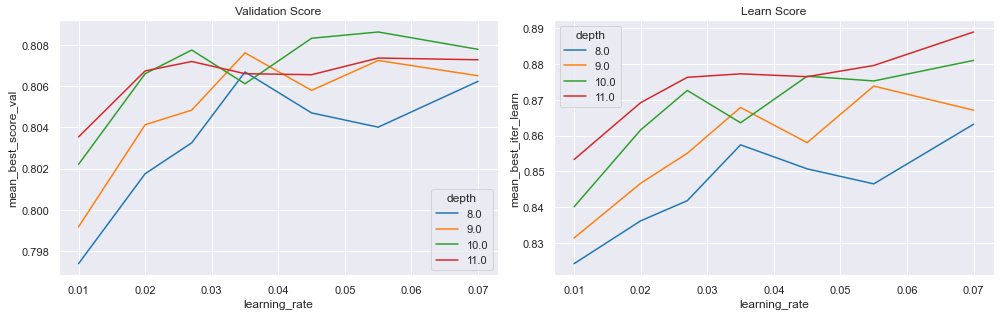

In [66]:
BIG = pd.read_csv('param_dicts/BIG_DEPTH_LR.csv', sep=';', index_col=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))
palette = sns.color_palette("tab10", n_colors=4) 

g1=sns.lineplot(data=BIG, x="learning_rate", y="mean_best_score_val", hue="depth", ax=ax[0], palette=palette) 
g2=sns.lineplot(data=BIG, x="learning_rate", y="mean_best_iter_learn", hue="depth", ax=ax[1], palette=palette) 
ax[0].set_title('Validation Score')
ax[1].set_title('Learn Score');
plt.tight_layout()

Лучшее среднее качество ***Accuracy*** на кроссвалидации ~ **0.80862** с гиперпараметрами `depth=10`, `learning_rate=0.055`.

Зафиксируем лучшие `depth` и `learning_rate`. Переберём также сеткой `bootstrap_type : ['Bernoulli', 'MVS', 'Bayesian']`, `rsm : [0.3, 0.4, 0.45, 0.5, 0.55, 0.65, 0.7, 0.77, 0.82, 0.88, 1]`:

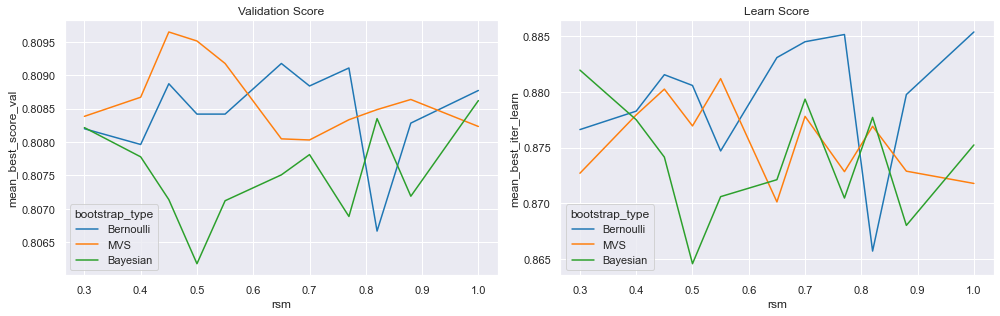

In [68]:
BIG = pd.read_csv('param_dicts/BIG_rsm_bootstrap.csv', sep=';', index_col=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))
palette = sns.color_palette("tab10", n_colors=3) 

g1=sns.lineplot(data=BIG, x="rsm", y="mean_best_score_val", hue="bootstrap_type", ax=ax[0], palette=palette) 
g2=sns.lineplot(data=BIG, x="rsm", y="mean_best_iter_learn", hue="bootstrap_type", ax=ax[1], palette=palette) 
ax[0].set_title('Validation Score')
ax[1].set_title('Learn Score');
plt.tight_layout()

Лучшее среднее качество ***Accuracy*** на кроссвалидации ~ **0.80965** с гиперпараметрами `bootstrap_type=MVS`, `rsm=0.45`.

Теперь к набору параметров `depth=10`, `learning_rate=0.055`, `bootstrap_type='MVS'`, `rsm=0.45` переберём также сеткой `subsample : [0.25, 0.4, 0.55, 0.75, 0.82, 0.88, 0.95, 1]` и `l2_leaf_reg : [1, 3, 5, 7]`:

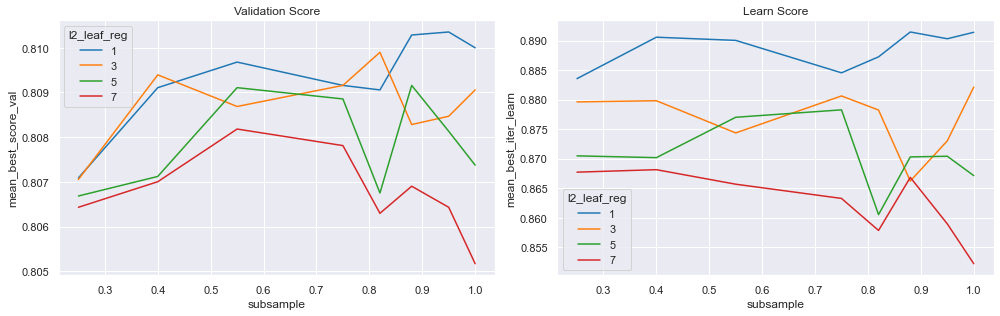

In [69]:
BIG = pd.read_csv('param_dicts/BIG_SUB_L2.csv', sep=';', index_col=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))
palette = sns.color_palette("tab10", n_colors=4) 

g1=sns.lineplot(data=BIG, x="subsample", y="mean_best_score_val", hue="l2_leaf_reg", ax=ax[0], palette=palette) 
g2=sns.lineplot(data=BIG, x="subsample", y="mean_best_iter_learn", hue="l2_leaf_reg", ax=ax[1], palette=palette) 
ax[0].set_title('Validation Score')
ax[1].set_title('Learn Score');
plt.tight_layout()

Лучшее среднее качество ***Accuracy*** на кроссвалидации ~ **0.8104** с гиперпараметрами `subsample=0.95` и `l2_leaf_reg=1`.

Итого: `Catboost` мы обучаем на параметрах: 

In [70]:
train_dataset = Pool(data=X, label=y) 

params = {
    "iterations":       2100,    
    "depth":            10,      
    "learning_rate":    0.055,   
    "bootstrap_type":   'MVS',   
    "rsm":              0.45,    
    "subsample":        0.95,    
    "l2_leaf_reg":      1        
} 

catboost_model = CatBoostClassifier(**params, random_seed=777, loss_function='MultiClass', eval_metric='Accuracy') 

catboost_model.fit(train_dataset, verbose=500)

0:	learn: 0.7215152	total: 54.2ms	remaining: 1m 53s
500:	learn: 0.8218350	total: 23.9s	remaining: 1m 16s
1000:	learn: 0.8515320	total: 48.7s	remaining: 53.5s
1500:	learn: 0.8706061	total: 1m 16s	remaining: 30.4s
2000:	learn: 0.8841077	total: 1m 42s	remaining: 5.08s
2099:	learn: 0.8869865	total: 1m 47s	remaining: 0us


In [71]:
catboost_model.evals_result_['learn']['Accuracy'][-1:][0]

0.886986531986532

Сохраним модель:

In [72]:
catboost_model.save_model('models/catboost_model_1lvl.cbm')

In [74]:
# catboost_model = CatBoostClassifier()
# catboost_model.load_model('models/catboost_model_1lvl.cbm')

# Инференс модели

In [73]:
def Inference(model, name_file):
    X_test = test[test.columns[1:]][imp_feat]
    y_hat = model.predict(X_test)
    y_pred = le_tar.inverse_transform(y_hat.ravel())
    data = pd.DataFrame(zip(test['id'], y_pred), 
                        columns = ['id', 'status_group']).to_csv(name_file,
                                                                 sep=',',
                                                                 index=False)

**Submission** отправленный на проверку выдал качество ***Accuracy = 0.8173***

In [79]:
Inference(catboost_model, 'subs/final_prediction_30082024_1.csv') # 0.8173

# <center> 🎸 `RandomizedSearchCV` </center>

<div class="alert alert-info">

**Небольшое пояснение:** Можно перебирать гиперпараметры с помощью `RandomizedSearchCV`: например используя `CatBoostClassifier`. Минимизируется по эпохам всегда `loss_function` (например "MultiClass"), но нам следует указать метрику качества `eval_metric` ("Accuracy") для того, чтобы наблюдать в выведенных сообщениях не функцию потерь, а `eval-качество` на каждой эпохе на обучении (на тесте в данном формате не выводится). В сам `RandomizedSearchCV` следует также обязательно передать параметр `scoring` ("Accuracy"), чтобы именно эта метрика замерялась на всех тестовых фолдах, и потом усреднялась по всем этим фолдам. После обучения можно обратиться к результатам поиска: `random_search.cv_results_`, это словарь результатов. `split*_test_score` – это замеряемое качество на фолде **`*`**. `mean_test_score` – это итоговый результат, усреднение качества `scoring` ("Accuracy") по всем фолдам. Это значение возвращается через атрибут:  `random_search.best_score_`, а лучшие параметры можно получить: `random_search.best_params_`.
    
Лучшую модель можно получить так: `random_search.best_estimator_`, и она предварительно уже обучена на всех фолдах. И она и осуществляет инференс.


<div class="alert alert-info">
    
Стоит сказать, что качество на тестовых фолдах измеряется **последней итерацией**, а не лучшей итерацией. В `random_search.cv_results_` значение `split0_test_score` эквивалентно `split0_last_score_val` в нашем `CustomSearchCV`. И `mean_test_score` ~ `mean_last_score_val`.

<div class="alert alert-info">
    
Из минусов: 
* нет возможности воспользоваться ранней остановкой `early_stopping` в `CatBoostClassifier`, кол-во деревьев на всех фолдах фиксированное, **так как параметры модели, которую мы проверяем на разных фолдах, должны быть одинаковыми**.   
* в выведенных сообщениях не будет выводиться информация о качестве тестов каждой эпохи, только качество обучения. Поэтому иногда лучше кастомить собственный класс перебора параметров.  

In [ ]:
param_distribution = {
    "iterations": [2500], #2100
    'depth': [10],
    'learning_rate': [0.055],
    'bootstrap_type': ['MVS'],
    'rsm': [0.45],
    "subsample":[0.95],
    "l2_leaf_reg":[1]
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

cat_model = CatBoostClassifier(random_seed=777, loss_function="MultiClass", eval_metric='Accuracy', task_type='CPU')
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=777)

random_search = RandomizedSearchCV(cat_model, param_distributions=param_distribution,
                                   scoring='accuracy', n_iter=1, cv=kf)
random_search.fit(X, y,
                verbose=250,
                plot=False)

In [ ]:
random_search.best_params_, random_search.best_score_  

In [ ]:
pd.DataFrame(random_search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
random_search.best_estimator_ # .best_score_

# 1 Level: `XGBClassifier` 🚀

С помощью `RandomizedSearchCV` выполним перебор параметров на кроссвалидации, чтобы "выловить" наилучшие параметры у `XGBClassifier`:

In [126]:
param_test1 = {
 'subsample': [0.7],
 'n_estimators': [110, 150, 200, 250],            # [50, 100, 150, 200, 350, 450, 550, 825, 1000],
 'max_depth': [10],                               # [4, 6, 8, 9, 10, 11, 13],
 'colsample_bytree': [0.7],
 'min_child_weight' : [1],                        # range(1, 6, 1),
 'eta': [0.05, 0.1, 0.2, 0.25, 0.3],              # [0.05, 0.1, 0.2, 0.25, 0.3]
 'gamma' : [num / 10 for num in range(1, 15, 1)],
}

In [127]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=111)

hyper_search = RandomizedSearchCV(XGBClassifier(), param_test1, n_iter=40, scoring='accuracy', 
                                  cv=kf, n_jobs=-1, refit=True, random_state=123,
                                  verbose=2)
hyper_search.fit(X, y)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [128]:
hyper_search.best_params_

{'subsample': 0.7,
 'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 10,
 'gamma': 0.4,
 'eta': 0.2,
 'colsample_bytree': 0.7}

In [129]:
hyper_search.best_score_

0.8086531986531987

In [131]:
# best_model_xgb = hyper_search.best_estimator_

In [132]:
def acc(y_true, y_pred):
    y_pred_final = y_pred.argmax(axis=1)
    return accuracy_score(y_true, y_pred_final)

In [133]:
param_test = {
 'n_estimators':       150,
 'max_depth':          10,    
 'subsample':          0.7,
 'min_child_weight':   1,
 'colsample_bytree':   0.7,    
 'gamma':              0.4,
 'eta':                0.2,
}
xgb_model = XGBClassifier(**param_test, eval_metric=acc, n_jobs=-1, verbosity=1)
evals = [(X, y)]
xgb_model.fit(X, y, eval_set=evals, verbose=50)

[0]	validation_0-mlogloss:0.97297	validation_0-acc:0.76811
[50]	validation_0-mlogloss:0.41493	validation_0-acc:0.83744
[100]	validation_0-mlogloss:0.34748	validation_0-acc:0.86608
[149]	validation_0-mlogloss:0.30303	validation_0-acc:0.88771


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2,
              eval_metric=<function acc at 0x7fce4371bee0>, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=-1,
              num_parallel_tree=None, ...)

In [139]:
xgb_model.evals_result()['validation_0']['acc'][-1:][0]

0.88771

**Submission** отправленный на проверку выдал качество ***Accuracy = 0.8172***

In [145]:
Inference(xgb_model, 'subs/final_prediction_30082024_2.csv')

Сохраним модель:

In [144]:
xgb_model.save_model('models/xgboost_model_1lvl.model') 

In [145]:
# xgb_model = XGBClassifier()
# xgb_model.load_model('models/xgboost_model_1lvl.model')

# 1 Level: `RandomForestClassifier` 🪵

Обучим следующую модель – случайный лес. И найдём лучшие параметры для неё:

In [42]:
mypipeline = Pipeline([
    ('forest', RandomForestClassifier())
])

In [43]:
param_grid_base = {
              'forest__n_estimators': [340],
              'forest__min_samples_split': [4],
              'forest__min_samples_leaf': [1],
              'forest__max_features': [24],
              'forest__max_depth': [25]
}

In [44]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=333)

hyper_search = RandomizedSearchCV(mypipeline, param_grid_base, n_iter=1, scoring='accuracy', 
                                  cv=kf, n_jobs=-1, refit=True, random_state=333,
                                  verbose=2)
hyper_search.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [49]:
hyper_search.best_score_, hyper_search.best_params_   

(0.8115488215488216,
 {'forest__n_estimators': 340,
  'forest__min_samples_split': 4,
  'forest__min_samples_leaf': 1,
  'forest__max_features': 24,
  'forest__max_depth': 25})

In [373]:
# dfdf = pd.DataFrame(hyper_search.cv_results_)
# dfdf.sort_values(by = ['mean_test_score'], ascending = False)
# rf_model = hyper_search.best_estimator_

In [148]:
params = {
'n_estimators':       340,
'min_samples_split':  4,
'min_samples_leaf':   1,
'max_features':       24,
'max_depth':          25  
}

rf_model = RandomForestClassifier(**params, random_state=777)
rf_model.fit(X, y)

/Users/gregor/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=25, max_features=24, min_samples_split=4,
                       n_estimators=340, random_state=777)

In [149]:
y_pred_train = rf_model.predict(X)

print(accuracy_score(y, y_pred_train))

0.9230134680134681


Инференс случайного леса составил ***Accuracy = 0.8204***. Ого! Даже круче бустингов..

In [158]:
Inference(rf_model, 'subs/final_prediction_31082024_1.csv')

Сохраним модель:

In [157]:
joblib.dump(rf_model, 'models/random_forest_model_1lvl.joblib')

In [158]:
# rf_model = joblib.load('models/random_forest_model_1lvl.joblib')

# 1 Level: `KNeighborsClassifier` 🕸️

Следующая модель: KNN, причём признаки будем стандартизовывать с помощью `StandardScaler`, это важно для метрических алгоритмов.

In [160]:
mypipeknn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [161]:
# paramknn = {
#     'knn__n_neighbors': range(5, 40, 1),
#     'knn__weights': ['uniform', 'distance'],
#     'knn__metric': ['minkowski', 'euclidean', 'chebyshev', 'manhattan', 'canberra'],
#     'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
# }

paramknn = {
 'knn__weights': ['distance'],
 'knn__n_neighbors': [17],
 'knn__metric': ['canberra'],
 'knn__algorithm': ['auto']
}

In [162]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=222)     

In [163]:
hyper_search = RandomizedSearchCV(mypipeknn, paramknn, n_iter=1, scoring='accuracy', 
                                  cv=kf, n_jobs=-1, refit=True, random_state=643,
                                  verbose=2)
hyper_search.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/gregor/miniconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [164]:
hyper_search.best_params_

{'knn__weights': 'distance',
 'knn__n_neighbors': 17,
 'knn__metric': 'canberra',
 'knn__algorithm': 'auto'}

In [165]:
hyper_search.best_score_

0.785942760942761

In [166]:
knn_model = hyper_search.best_estimator_ # 0.8006

In [167]:
knn_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='canberra', n_neighbors=17,
                                      weights='distance'))])

In [ ]:
#Добаввить scaler
# params = {
#     'n_neighbors' :     17,
#      'weights'     :     'distance',
#      'metric'      :     'canberra',
#      'algorithm'   :     'auto'  
# }

# knn_model = KNeighborsClassifier(**params) 
# knn_model.fit(X, y)
# y_pred_train = knn_model.predict(X)
# accuracy = accuracy_score(y, y_pred_train)
# print(accuracy)

Инференс KNN составил ***Accuracy = 0.8005***. Knn даст прирост в стекинге моделей 😃

In [168]:
Inference(knn_model, 'subs/final_prediction_31082024_knn.csv')

Сохраним модель:

In [169]:
joblib.dump(knn_model, 'models/knn_model_1lvl.joblib')

['models/knn_model_1lvl.joblib']

In [170]:
# knn_model = joblib.load('models/knn_model_1lvl.joblib')

# Stacking 🤖

<div class="alert alert-info">

**Стекинг моделей** — это метод ансамблевого обучения, который позволяет комбинировать предсказания нескольких моделей, чтобы улучшить общую производительность.

После обучения базовых моделей получим их **предсказания на каждом фолде данных** (рисунок ниже).

Эти предсказания базовых моделей будут новыми признаками (**мета-признаки**) для обучения мета-модели (второго уровня).
    
Также, нужны прогнозы всех базовых моделей на тест, причём обученных уже на всех данных.    

<img src='images/stack_schema.gif' />

In [171]:
models = [
  catboost_model,
  xgb_model,    
  rf_model,
  knn_model  
]

X_test = test[test.columns[1:]]
X_te = X_test[imp_feat]

# предсказания для трэйна всех моделей через кроссвалидацию
S_train_B_scratch = np.zeros((X.shape[0], len(models)*3))

# предсказания всех моделей для теста
S_test_B_scratch = np.zeros((X_te.shape[0], len(models)*3))

In [172]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore', category=DataConversionWarning)

In [173]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)     
for i in range(len(models)):
    for fold_counter, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]  
        
        if i < 2: _ = models[i].fit(X_train_cv, y_train_cv, verbose=False)
        else: _ = models[i].fit(X_train_cv, y_train_cv)

        S_train_B_scratch[test_index, 3*i : ((3*i)+3)] = models[i].predict_proba(X_test_cv) 

In [174]:
# Обучаемся на полном трэйне, предсказываем тест
for i in range(len(models)):
    if i < 2: _ = models[i].fit(X, y, verbose=False)
    else: _ = models[i].fit(X, y)
    S_test_B_scratch[:, 3*i : ((3*i)+3)]  = models[i].predict_proba(X_te)

--------------

# 2 Level: `RandomForestClassifier` 🌳🌴

<img src='images/diagramma2.png' />

Обучим случайный лес на ответах предыдущих четырёх моделей и на нашем признаковом пространстве. Найдём наилучшие параметры.

In [176]:
TRAIN = X.copy()
TRAIN[['cat0','cat1','cat2']] = S_train_B_scratch[:, 0:3]
TRAIN[['xgb0', 'xgb1', 'xgb2']] = S_train_B_scratch[:, 3:6]
TRAIN[['rf0', 'rf1', 'rf2']] = S_train_B_scratch[:, 6:9]
TRAIN[['knn0', 'knn1', 'knn2']] = S_train_B_scratch[:, 9:12]

TEST = X_te.copy()
TEST[['cat0','cat1','cat2']] = S_test_B_scratch[:, 0:3]
TEST[['xgb0', 'xgb1', 'xgb2']] = S_test_B_scratch[:, 3:6]
TEST[['rf0', 'rf1', 'rf2']] = S_test_B_scratch[:, 6:9]
TEST[['knn0', 'knn1', 'knn2']] = S_test_B_scratch[:, 9:12]

In [177]:
mypipeline = Pipeline([
    ('forest', RandomForestClassifier())
])

In [178]:
# param_grid_base = {
#               'forest__n_estimators':            np.arange(350, 400, 10),
#               'forest__min_samples_split':       range(1, 5),
#               'forest__min_samples_leaf':        [1, 2, 3],
#               'forest__max_features':            [8, 10, 13, 14, 15, 16, 17, 18, 20, 23, 26, 30],
#               'forest__max_depth':               np.arange(10, 26, 2) 
# }

param_grid_base = {
              'forest__n_estimators':            [350],
#               'forest__min_samples_split':       range(1, 5),
#               'forest__min_samples_leaf':        [1, 2, 3],
              'forest__max_features':            [10],
              'forest__max_depth':               [21]
}

In [180]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777) 

hyper_search = RandomizedSearchCV(mypipeline, param_grid_base, n_iter=1, scoring='accuracy', 
                                  cv=kf, n_jobs=-1, refit=True, random_state=333,
                                  verbose=2)
hyper_search.fit(TRAIN, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [181]:
hyper_search.best_params_, hyper_search.best_score_  

({'forest__n_estimators': 350,
  'forest__max_features': 10,
  'forest__max_depth': 21},
 0.8202356902356902)

In [182]:
hyper_search.cv_results_

{'mean_fit_time': array([51.28556695]),
 'std_fit_time': array([0.10938308]),
 'mean_score_time': array([2.21605363]),
 'std_score_time': array([0.01158005]),
 'param_forest__n_estimators': masked_array(data=[350],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_forest__max_features': masked_array(data=[10],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_forest__max_depth': masked_array(data=[21],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'forest__n_estimators': 350,
   'forest__max_features': 10,
   'forest__max_depth': 21}],
 'split0_test_score': array([0.81675084]),
 'split1_test_score': array([0.81994949]),
 'split2_test_score': array([0.81944444]),
 'split3_test_score': array([0.82222222]),
 'split4_test_score': array([0.82281145]),
 'mean_test_score': array([0.82023569]),
 'std_test_score': array([0.00216485]),
 'rank_test_score': array([1], dtype=in

In [372]:
best_model_stack_rf = hyper_search.best_estimator_ 

In [183]:
joblib.dump(best_model_stack_rf, 'models/best_model_stack_rf_17092024_1.joblib')
# best_model_stack_rf = joblib.load('models/best_model_stack_rf_17092024_1.joblib')

In [184]:
best_model_stack_rf

Pipeline(steps=[('forest',
                 RandomForestClassifier(max_depth=21, max_features=10,
                                        n_estimators=350))])

# Final Predictions 🔮

Записываем прогнозы модели в `.csv` файл и проверяем на тесте:

In [373]:
y_hat = best_model_stack_rf.predict(TEST) 
y_pred = le_tar.inverse_transform(y_hat.ravel())
data = pd.DataFrame(zip(test['id'], y_pred), 
                    columns = ['id', 'status_group']).to_csv('subs/final_prediction_17092024_1.csv',
                                                             sep=',',
                                                             index=False)

Данный предикт даёт результат **0.8231**, но можно подобрать гиперпараметры, дающие ещё больше accuracy. *(Получалось выбить* ***0.8238***, *правда модель не сохранил)*

# Rank 🏆

<img src='images/place_pump.png' />

---